In [1]:
# https://www.slideshare.net/hoondori97/switch-transformers-paper-review

# https://ichi.pro/ko/google-ui-switch-transformer-ihae-158654144880486

## **구현 미완성 상태**
- loss 가 1로 수렴하고 test accuracy 가 50%로 일정하게 나오는 문제가 있음

# Text classification with Switch Transformer

## Introduction

This example demonstrates the implementation of the
[Switch Transformer](https://arxiv.org/abs/2101.03961) model for text
classification.

The Switch Transformer replaces the feedforward network (FFN) layer in the standard
Transformer with a Mixture of Expert (MoE) routing layer, where each expert operates
independently on the tokens in the sequence. This allows increasing the model size without
increasing the computation needed to process each example.

Note that, for training the Switch Transformer efficiently, data and model parallelism
need to be applied, so that expert modules can run simultaneously, each on its own accelerator.
While the implementation described in the paper uses the
[TensorFlow Mesh](https://github.com/tensorflow/mesh) framework for distributed training,
this example presents a simple, non-distributed implementation of the Switch Transformer
model for demonstration purposes.

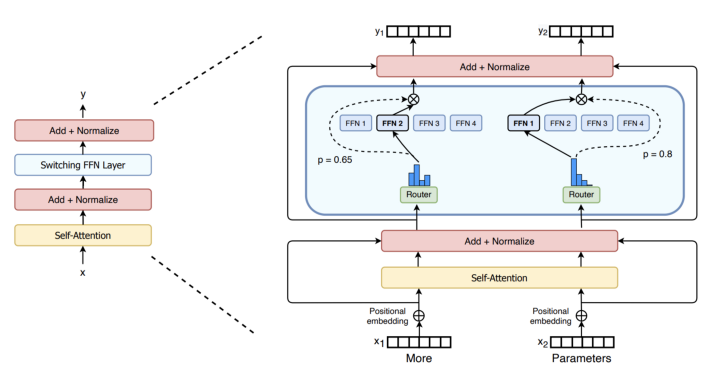

* 토큰 수 / 전문가 수

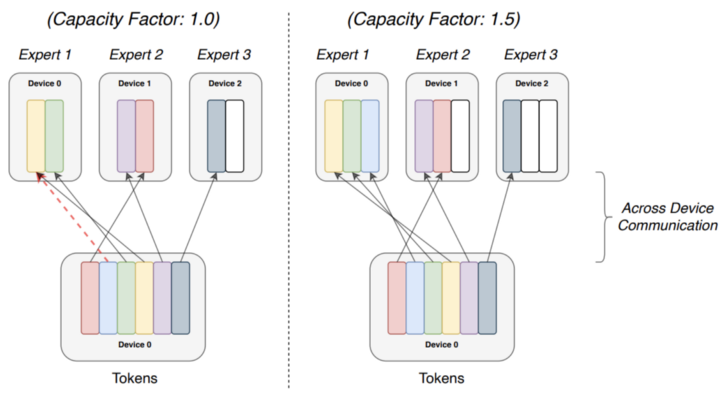

## Setup

In [1]:
# import tensorflow as tf
# from tensorflow import keras
# from tensorflow.keras import layers

import torch
import torch.nn as nn

import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import glob
import pandas as pd
import math

## Download and prepare dataset 
* ibdb dataset (text gen with GPT)

### 데이터프레임 직접 생성

In [2]:
def get_text_list_from_files(files):
    text_list = []
    for name in files:
        with open(name) as f:
            for line in f:
                text_list.append(line)
    return text_list

# label -> pos : 1, neg : 0 
def get_data_from_text_files(folder_name):

    pos_files = glob.glob("datasets/aclImdb/" + folder_name + "/pos/*.txt")
    pos_texts = get_text_list_from_files(pos_files)
    neg_files = glob.glob("datasets/aclImdb/" + folder_name + "/neg/*.txt")
    neg_texts = get_text_list_from_files(neg_files)
    df = pd.DataFrame(
        {
            "review": pos_texts + neg_texts,
            "sentiment": [1] * len(pos_texts) + [0] * len(neg_texts),
        }
    )
    # sampling 후 reset_index : index 초기화 (https://yganalyst.github.io/data_handling/Pd_2/)
    # 두 데이터 프레임을 합치면서 index를 0부터 초기화, drop=True : 기존 index를 버림
    df = df.sample(len(df)).reset_index(drop=True)
    return df


train_df = get_data_from_text_files("train")
test_df = get_data_from_text_files("test")

all_data = train_df.append(test_df)

In [3]:
all_data.head()

,review,sentiment


### torchtext 이용

In [7]:
# https://wikidocs.net/60691
# https://pytorch.org/text/_modules/torchtext/data/field.html

import torchtext
from torchtext.legacy import data, datasets

In [8]:
max_len = 200  # Only consider the first 200 words of each movie review

TEXT = data.Field(sequential=True, fix_length=max_len, batch_first=True, lower=True) # text는 sequence 
LABEL = data.Field(sequential=False, batch_first=True)           # label은 sequence가 아님

trainset, testset = datasets.IMDB.splits(TEXT, LABEL)

In [9]:
print("# of train : ", len(trainset))
print("# of test : ", len(testset))

# of train :  25000
# of test :  25000


In [10]:
print(trainset[1])
print(vars(trainset[1])) # __dict__ 어트리뷰트를 반환한다. (객체(object)의 내부 변수가 저장된 딕셔너리)

{'text': ['this', 'is', 'the', 'touching', 'story', 'of', 'two', 'families', 'in', 'israel', 'and', 'the', 'relationships', 'within', 'each', 'family.', 'each', 'family', 'has', 'a', 'gay', 'son.', 'the', 'stories', 'are', 'interrelated', 'at', 'that', 'point', 'but', 'this', 'film', 'is', 'about', 'all', 'of', 'the', 'family', 'members,', 'not', 'just', 'the', 'two', 'sons.', 'the', 'portraits', 'of', 'each', 'of', 'the', 'family', 'members', 'in', 'both', 'families', 'are', 'well', 'drawn', 'and', 'the', 'story', 'is', 'consistently', 'interesting', 'if', 'a', 'bit', 'bleak.'], 'label': 'pos'}


### build vocab

In [11]:
# vocab_size = 20000  # Only consider the top 20k words

In [12]:
TEXT.build_vocab(trainset, min_freq=14) # 단어 집합 생성
LABEL.build_vocab(trainset)

In [13]:
vocab_size = len(TEXT.vocab)
n_classes = 2
print('단어 집합의 크기 : {}'.format(vocab_size))
print('클래스의 개수 : {}'.format(n_classes))

단어 집합의 크기 : 20988
클래스의 개수 : 2


In [14]:
print(TEXT.vocab.stoi) # 각 단어의 정수 인덱스가 저장되어져 있는 딕셔너리 객체에 접근

defaultdict(<bound method Vocab._default_unk_index of <torchtext.legacy.vocab.Vocab object at 0x7f3ff97e51d0>>, {'<unk>': 0, '<pad>': 1, 'the': 2, 'a': 3, 'and': 4, 'of': 5, 'to': 6, 'is': 7, 'in': 8, 'i': 9, 'this': 10, 'that': 11, 'it': 12, '/><br': 13, 'was': 14, 'as': 15, 'for': 16, 'with': 17, 'but': 18, 'on': 19, 'movie': 20, 'his': 21, 'are': 22, 'not': 23, 'film': 24, 'you': 25, 'have': 26, 'he': 27, 'be': 28, 'at': 29, 'one': 30, 'by': 31, 'an': 32, 'they': 33, 'from': 34, 'all': 35, 'who': 36, 'like': 37, 'so': 38, 'just': 39, 'or': 40, 'has': 41, 'her': 42, 'about': 43, "it's": 44, 'some': 45, 'if': 46, 'out': 47, 'what': 48, 'very': 49, 'when': 50, 'more': 51, 'there': 52, 'she': 53, 'would': 54, 'even': 55, 'good': 56, 'my': 57, 'only': 58, 'their': 59, 'no': 60, 'really': 61, 'had': 62, 'which': 63, 'can': 64, 'up': 65, 'were': 66, 'see': 67, 'than': 68, 'we': 69, '-': 70, 'been': 71, 'into': 72, 'get': 73, 'will': 74, 'story': 75, 'much': 76, 'because': 77, 'most': 78, '

In [15]:
vocab_dict = TEXT.vocab.stoi

In [16]:
vocab_dict

defaultdict(<bound method Vocab._default_unk_index of <torchtext.legacy.vocab.Vocab object at 0x7f3ff97e51d0>>,
            {'<unk>': 0,
             '<pad>': 1,
             'the': 2,
             'a': 3,
             'and': 4,
             'of': 5,
             'to': 6,
             'is': 7,
             'in': 8,
             'i': 9,
             'this': 10,
             'that': 11,
             'it': 12,
             '/><br': 13,
             'was': 14,
             'as': 15,
             'for': 16,
             'with': 17,
             'but': 18,
             'on': 19,
             'movie': 20,
             'his': 21,
             'are': 22,
             'not': 23,
             'film': 24,
             'you': 25,
             'have': 26,
             'he': 27,
             'be': 28,
             'at': 29,
             'one': 30,
             'by': 31,
             'an': 32,
             'they': 33,
             'from': 34,
             'all': 35,
             'who': 36,
           

In [17]:
decode_dict = { vocab_dict[k]:k for k in vocab_dict}
decode_dict[0]='<unk>'
decode_dict

{0: '<unk>',
 1: '<pad>',
 2: 'the',
 3: 'a',
 4: 'and',
 5: 'of',
 6: 'to',
 7: 'is',
 8: 'in',
 9: 'i',
 10: 'this',
 11: 'that',
 12: 'it',
 13: '/><br',
 14: 'was',
 15: 'as',
 16: 'for',
 17: 'with',
 18: 'but',
 19: 'on',
 20: 'movie',
 21: 'his',
 22: 'are',
 23: 'not',
 24: 'film',
 25: 'you',
 26: 'have',
 27: 'he',
 28: 'be',
 29: 'at',
 30: 'one',
 31: 'by',
 32: 'an',
 33: 'they',
 34: 'from',
 35: 'all',
 36: 'who',
 37: 'like',
 38: 'so',
 39: 'just',
 40: 'or',
 41: 'has',
 42: 'her',
 43: 'about',
 44: "it's",
 45: 'some',
 46: 'if',
 47: 'out',
 48: 'what',
 49: 'very',
 50: 'when',
 51: 'more',
 52: 'there',
 53: 'she',
 54: 'would',
 55: 'even',
 56: 'good',
 57: 'my',
 58: 'only',
 59: 'their',
 60: 'no',
 61: 'really',
 62: 'had',
 63: 'which',
 64: 'can',
 65: 'up',
 66: 'were',
 67: 'see',
 68: 'than',
 69: 'we',
 70: '-',
 71: 'been',
 72: 'into',
 73: 'get',
 74: 'will',
 75: 'story',
 76: 'much',
 77: 'because',
 78: 'most',
 79: 'how',
 80: 'other',
 81: 'als

In [18]:
batch_size = 50  # Batch size.

train_iter, test_iter = data.BucketIterator.splits(
        (trainset, testset), batch_size=batch_size, shuffle=True)

In [19]:
# pos : 2, neg : 1
for batch_item in train_iter:
    print(batch_item.text)
    print(batch_item.text.shape)
    print('\n')
    print(batch_item.label)
    print(batch_item.label.shape)
    
    print('\n')
    print([decode_dict[idx.item()] for idx in batch_item.text[0]])
    print([decode_dict[idx.item()] for idx in batch_item.text[1]])
    break

tensor([[ 113, 1903, 4373,  ...,    1,    1,    1],
        [  10, 2932,   24,  ...,    1,    1,    1],
        [   9,  308,    2,  ...,   67, 9329,    4],
        ...,
        [4795,    0,   13,  ...,  700,    0,    4],
        [9532,    0,   29,  ...,    1,    1,    1],
        [  12,    7,  531,  ...,    1,    1,    1]])
torch.Size([50, 200])


tensor([1, 2, 1, 1, 2, 1, 2, 1, 1, 2, 2, 2, 2, 1, 2, 1, 1, 1, 2, 1, 1, 1, 1, 2,
        1, 1, 2, 2, 1, 1, 1, 1, 2, 2, 1, 2, 1, 1, 2, 1, 2, 1, 2, 1, 1, 1, 1, 2,
        1, 1])
torch.Size([50])


['did', 'anybody', 'succeed', 'in', 'getting', 'in', 'this', '<unk>', '/><br', "/>it's", 'a', 'total', 'mess', 'to', 'me:', 'a', 'vague', '<unk>', 'context', 'instead', 'of', 'a', 'plot,', 'a', 'pretentious', 'imagery', 'as', '<unk>', 'en', 'scene', 'and', 'it', 'lasts', 'two', '<unk>', '/><br', '<unk>', 'on', 'those', 'who', 'wasted', 'money', 'here.', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '

In [20]:
next(iter(train_iter)).text

tensor([[ 4795, 15709,   795,  ...,    27, 17047,    40],
        [   12,    14,   824,  ...,    42, 16459,    48],
        [ 5191,  9512,   344,  ...,     1,     1,     1],
        ...,
        [    9,   120,     2,  ...,     1,     1,     1],
        [ 7005,   200,    10,  ...,     1,     1,     1],
        [    0,   129,    89,  ...,     1,     1,     1]])

In [21]:
next(iter(train_iter)).label

tensor([1, 2, 2, 1, 2, 2, 2, 2, 2, 1, 1, 2, 2, 1, 2, 1, 1, 2, 1, 1, 2, 2, 1, 2,
        2, 1, 2, 2, 2, 1, 2, 1, 1, 2, 1, 2, 1, 1, 2, 2, 2, 1, 1, 2, 1, 2, 1, 2,
        1, 1])

In [22]:
next(iter(train_iter)).text.shape

torch.Size([50, 200])

In [23]:
train_iter, test_iter = data.BucketIterator.splits(
        (trainset, testset), batch_size=batch_size, shuffle=True)

In [24]:
# 500 x 50 = 25000 개
print('훈련 데이터의 미니 배치의 개수 : {}'.format(len(train_iter)))
print('테스트 데이터의 미니 배치의 개수 : {}'.format(len(test_iter)))

훈련 데이터의 미니 배치의 개수 : 500
테스트 데이터의 미니 배치의 개수 : 500


## Define hyperparameters

In [25]:
# embed_dim = d_model
embed_dim = 32  # Embedding size for each token.
num_heads = 2  # Number of attention heads
ff_dim = 32  # Hidden layer size in feedforward network.
num_experts = 10  # Number of experts used in the Switch Transformer.
learning_rate = 0.001  # Learning rate.
dropout_rate = 0.25  # Dropout rate.
num_epochs = 3  # Number of epochs.
# maxlen = num_tokens_per_example
num_tokens_per_example = 200
batch_size = 50

num_tokens_per_batch = (
    batch_size * num_tokens_per_example
)  # Total number of tokens per batch.
print(f"Number of tokens per batch: {num_tokens_per_batch}")

Number of tokens per batch: 10000


## Implement token & position embedding layer

It consists of two seperate embedding layers, one for tokens, one for token index (positions).

In [26]:
class TokenAndPositionEmbedding(nn.Module):
    def __init__(self, vocab_size, max_len, embed_dim):
        """
        :param vocab_size: total vocab size
        :param max_len: max length of seqeunce
        :param embed_dim: embedding size of token embedding
        """
        super().__init__()
        self.token_emb = nn.Embedding(num_embeddings=vocab_size, embedding_dim=embed_dim, padding_idx=1)
        self.pos_emb = nn.Embedding(num_embeddings=max_len, embedding_dim=embed_dim)

    def forward(self, sequence):

        max_seq_len = sequence.shape[-1]

        positions = torch.tensor(range(max_seq_len)).to(torch.device('cuda' if torch.cuda.is_available() else 'cpu'))
        positions = self.pos_emb(positions)
        emb_out = self.token_emb(sequence) + positions 
        return emb_out

## Implement the feedforward network

This is used as the Mixture of Experts in the Switch Transformer.

In [27]:
# 이 함수에 의해 expert 개수만큼 FFN 생성하게 됨
def create_feedforward_network(embed_dim, ff_dim):
    return nn.Sequential(
        nn.Linear(embed_dim, ff_dim), 
        nn.ReLU(),
        nn.Linear(ff_dim, ff_dim)
    ).to(torch.device('cuda' if torch.cuda.is_available() else 'cpu'))


## Implement the load-balanced loss

This is an auxiliary loss to encourage a balanced load across experts.

1. router_probs [tokens_per_batch, num_experts]

> * 토큰마다 expert 개수만큼 probability를 계산하게되고,가장 높은 probability에 해당하는expert의 FFN을 타고 output 내보냄

2. expert_mask [tokens_per_batch, num_experts]

> * 가장 높은 probability의 위치를 one-hot으로 표현한 것

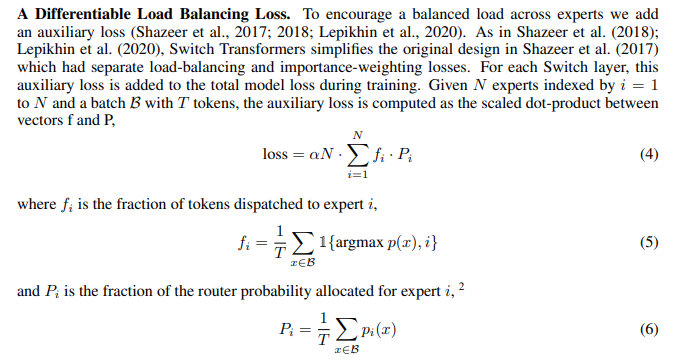

* The auxiliary loss of Equation (4) achieves encourages uniform routing since it is
minimized under a uniform distribution

In [28]:

def load_balanced_loss(router_probs, expert_mask):
    # router_probs [tokens_per_batch, num_experts] is the probability assigned for
    # each expert per token. expert_mask [tokens_per_batch, num_experts] contains
    # the expert with the highest router probability in one−hot format.
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    num_experts = torch.tensor(expert_mask.shape[-1]).to(device)
    # Get the fraction of tokens routed to each expert.
    # density is a vector of length num experts that sums to 1.
    density = torch.mean(expert_mask.type(torch.FloatTensor), dim=0).to(device)
    # Get fraction of probability mass assigned to each expert from the router
    # across all tokens. density_proxy is a vector of length num experts that sums to 1.
    density_proxy = torch.mean(router_probs, dim=0).to(device)
    # Want both vectors to have uniform allocation (1/num experts) across all
    # num_expert elements. The two vectors will be pushed towards uniform allocation
    # when the dot product is minimized.
    loss = torch.mean(density_proxy * density) * torch.tensor(num_experts ** 2).type(torch.FloatTensor)
    return loss


### Implement the router as a layer

* router_probs : linear projection을 통해서 expert 마다 logit값을 구한 후 softmax 확률 도출

```
# using varying `axis` values
y = torch.tensor([[2, 4, 6, 8], [1,3,5,7]])
torch.cumsum(y, dim=0)

tensor([[ 2,  4,  6,  8],
        [ 3,  7, 11, 15]])
        
```

In [29]:

class Router(nn.Module):
    def __init__(self, embed_dim, num_experts, expert_capacity):
        super().__init__()
        self.num_experts = num_experts
        self.route = nn.Linear(embed_dim, num_experts)
        self.expert_capacity = expert_capacity
        

    def forward(self, x, training=False):
        # inputs shape: [tokens_per_batch, embed_dim]
        # router_logits shape: [tokens_per_batch, num_experts]
        router_logits = self.route(x)

        if training:
            # Add noise for exploration across experts. [0.9, 1.1]
            router_logits += torch.FloatTensor(router_logits.shape).uniform_(0.9, 1.1).to(torch.device('cuda' if torch.cuda.is_available() else 'cpu'))

        # Probabilities for each token of what expert it should be sent to.
        router_probs = F.softmax(router_logits, dim=-1)
        # Get the top−1 expert for each token. expert_gate is the top−1 probability
        # from the router for each token. expert_index is what expert each token
        # is going to be routed to.
        
        # 확률값, 확률값이 최대인 index
        expert_gate, expert_index = torch.topk(router_probs, k=1) # 10000, 1

        # expert_mask shape: [tokens_per_batch, num_experts]
        # 토큰 별로 행당하는 expert index를 one hot으로 표현
        expert_mask = F.one_hot(expert_index, num_classes=self.num_experts) # 10000, 1, 10

        # Compute load balancing loss.
        aux_loss = load_balanced_loss(router_probs, expert_mask)
        # print(f'expert balalancing loss ---> {aux_loss}')
        
        # Experts have a fixed capacity, ensure we do not exceed it. Construct
        # the batch indices, to each expert, with position in expert make sure that
        # not more that expert capacity examples can be routed to each expert.
        
        position_in_expert = (torch.cumsum(expert_mask, dim=0) * expert_mask).type(torch.int32) # 10000, 1, 10
        
        # Keep only tokens that fit within expert capacity.
        # 10000, 1, 10
        # true/false
        expert_mask *=torch.less(
                position_in_expert.type(torch.int32), self.expert_capacity
            )
        
        # tf.one_hot -> keras에서는 index 넘어가는 것 알아서 0으로 만들어 줌
        # torch.one_hot은 그렇지 안아서 직접 masking 해줌
        
        # Opinion : 0으로 되면 값 전달이 안되는데? -> 위의 balance loss 학습으로 균일하게 expert를 부여할 수 있도록 학습되는 과정에서 해결
        position_in_expert *= expert_mask

        # 10000, 1
        # one-hot encoding에서 capacity로 인해 masking 이 됐다면 0, masking 안 됐다면 1로 차원 축소
        expert_mask_flat = torch.sum(expert_mask, dim=-1)
        
        # Mask out the experts that have overflowed the expert capacity.
        # expert에 대한 확률값도 masking
        expert_gate *= expert_mask_flat
        
        # Combine expert outputs and scaling with router probability.
        # combine_tensor shape: [tokens_per_batch, num_experts, expert_capacity]
        
        # expert_gate   :  TensorShape([10000, 1])
        # expert_mask_flat   :   TensorShape([10000, 10])
        # torch.squeeze(F.one_hot(expert_index.long(), num_classes=self.num_experts)  :  TensorShape([10000, 10, 1000])

        # TensorShape([10000, 10, 1]) *  TensorShape([10000, 10, 1000])
        # TensorShape([10000, 10, 1000])
        
        # 결론 [tokens_per_batch, num_experts, expert_capacity] shape에 해당하는 expert probability가 들어간다!!
        # 어떤 토큰이 어떤 expert의 capacity 순서에서 확률값을 갖는지
        combined_tensor = torch.unsqueeze(
            expert_gate
            * expert_mask_flat
            * torch.squeeze(F.one_hot(expert_index.long(), num_classes=self.num_experts), 1),
            -1,
        ) * torch.squeeze(F.one_hot(position_in_expert.long(), num_classes=self.expert_capacity), 1)
       
        # Create binary dispatch_tensor [tokens_per_batch, num_experts, expert_capacity]
        # that is 1 if the token gets routed to the corresponding expert.
        
        # keras는 설명과 다르게 구현
        # 논문에 의하면 boolean이 맞음
        dispatch_tensor = (combined_tensor > 0).type(torch.float32)

        return dispatch_tensor, combined_tensor, aux_loss


### Implement a Switch layer

In [30]:

class Switch(nn.Module):
    def __init__(self, num_experts, embed_dim, num_tokens_per_batch, ff_dim, capacity_factor=1):
        super().__init__()
        self.num_experts = num_experts
        self.embed_dim = embed_dim
        self.experts = [
            create_feedforward_network(self.embed_dim, ff_dim) for _ in range(num_experts)
        ]

        self.expert_capacity = num_tokens_per_batch // self.num_experts
        self.router = Router(embed_dim, self.num_experts, self.expert_capacity)

    def forward(self, x):
        batch_size = x.shape[0]
        num_tokens_per_example = x.shape[1]

        # inputs shape:  [batch_size, num_tokens_per_example, embed_dim] -> [num_tokens_per_batch, embed_dim]
        # torch.Size([50, 200, 32]) -> torch.Size([10000, 32])
        inputs = torch.reshape(x, [num_tokens_per_batch, self.embed_dim])
        
        
        # dispatch_tensor shape: [expert_capacity, num_experts, tokens_per_batch]
        # combine_tensor shape: [tokens_per_batch, num_experts, expert_capacity]
        
        ######
        #  1
        ######
        # keras --> 둘 다 [10000, 10, 1000], 하나는 binary, 하나는 prob.
        dispatch_tensor, combine_tensor, aux_loss = self.router(inputs, training=True)
        
        ######
        #  2 dispatch_tensor (binary) 를 통해 FFN output 값 구함
        ######        
        # expert_inputs shape: [num_experts, expert_capacity, embed_dim]
        # [10000, 32] x [10000, 10, 1000] = [10, 1000, 32]
        # 아래 코드에 의해 10000개의 token이 10개의 expert, 각 1000개의 capacity에 할당됨
        expert_inputs = torch.einsum("ab,acd->cdb", inputs, dispatch_tensor)  # torch.Size([10, 1000, 32])
        expert_inputs = torch.reshape(
            expert_inputs, [self.num_experts, self.expert_capacity, self.embed_dim]
        )
        # Dispatch to experts
        expert_input_list = torch.unbind(expert_inputs, axis=0) # 행 단위로 분리 [1000,32]
        
        # 각 expert마다 해당 FFN으로 output 도출
        expert_output_list = [
            self.experts[idx](expert_input)
            for idx, expert_input in enumerate(expert_input_list)
        ]
        # expert_outputs shape: [expert_capacity, num_experts, embed_dim]
        # [1000, 10, 32]
        expert_outputs = torch.stack(expert_output_list, dim=1)

        ######
        #  3 combine (확률값) 이랑 곱해서 넘겨줌
        ######
        # expert_outputs_combined shape: [tokens_per_batch, embed_dim]
        # [1000, 10, 32] x [10000, 10, 1000] = [10000, 32]
        expert_outputs_combined = torch.einsum(
            "abc,xba->xc", expert_outputs, combine_tensor
        )
        # output shape: [batch_size, num_tokens_per_example, embed_dim]
        # [10000, 32] -> [50, 200, 32]
        outputs = torch.reshape(
            expert_outputs_combined,
            [batch_size, num_tokens_per_example, self.embed_dim]
        )
        return outputs, aux_loss


## Implement a Transformer block layer

In [31]:
class MultiHeadAttention(nn.Module):
    def __init__(self, heads, d_model, dropout = 0.0, d_k = None):
        super().__init__()
        
        self.d_model = d_model
        if d_k:
            self.d_k = d_k
        else:
            self.d_k = d_model // heads
        self.h = heads
        
        self.q_linear = nn.Linear(d_model, heads * d_k)
        self.v_linear = nn.Linear(d_model, heads * d_k)
        self.k_linear = nn.Linear(d_model, heads * d_k)
        self.out = nn.Linear(heads * d_k, d_model)

    def attention(self, q, k, v, d_k, mask=None, dropout=None):
        
        scores = torch.matmul(q, k.transpose(-2, -1)) /  math.sqrt(d_k)

        if mask is not None:
            mask = mask.unsqueeze(1)
            scores = scores.masked_fill(mask == 0, -1e9)

        scores = F.softmax(scores, dim=-1)

        if dropout is not None:
            scores = dropout(scores)

        output = torch.matmul(scores, v)
        
        return output
    
    def forward(self, q, k, v, mask=None):
                
        bs = q.size(0)
        len_q = q.size(1)
        
        # perform linear operation and split into h heads
        k = self.k_linear(k).view(bs, -1, self.h, self.d_k)
        q = self.q_linear(q).view(bs, -1, self.h, self.d_k)
        v = self.v_linear(v).view(bs, -1, self.h, self.d_k)
        
        # transpose to get dimensions bs * h * sl * d_model
        k = k.transpose(1,2)
        q = q.transpose(1,2)
        v = v.transpose(1,2)

       # calculate attention using function we will define next
        scores = self.attention(q, k, v, self.d_k, mask)                       
        # concatenate heads and put through final linear layer
        concat = scores.transpose(1,2).contiguous().view(bs, len_q, -1) 
        output = self.out(concat)
    
        return output


class Norm(nn.Module):
    def __init__(self, d_model, eps = 1e-6):
        super().__init__()
    
        self.size = d_model
        # create two learnable parameters to calibrate normalisation
        self.alpha = nn.Parameter(torch.ones(self.size))
        self.bias = nn.Parameter(torch.zeros(self.size))
        self.eps = eps
        
    def forward(self, x):
        norm = self.alpha * (x - x.mean(dim=-1, keepdim=True)) \
        / (x.std(dim=-1, keepdim=True) + self.eps) + self.bias
        return norm

In [32]:
# Encoder Block
class TransformerBlock(nn.Module):
    def __init__(self, embed_dim, num_heads, switch_ffn, dropout = 0.1):
        super().__init__()
        self.attn = MultiHeadAttention(heads=num_heads, d_model=embed_dim, d_k=embed_dim)
        # The ffn can be either a standard feedforward network or a switch
        # layer with a Mixture of Experts.
        self.ffn = switch_ffn
        self.norm_1 = Norm(embed_dim)
        self.norm_2 = Norm(embed_dim)
        self.dropout_1 = nn.Dropout(dropout)
        self.dropout_2 = nn.Dropout(dropout)
        
    def forward(self, x, mask=None):
        # x : torch.Size([50, 200, 32])
        # self attention + add&norm
        attn_output = self.attn(x, x, x, mask)
        attn_output = self.dropout_1(attn_output)
        norm_output = self.norm_1(x + attn_output)
        
        # ffn + add&norm
        ffn_output, aux_loss = self.ffn(norm_output)
        ffn_output = self.dropout_2(ffn_output)
        out = self.norm_2(norm_output + ffn_output)
        return out, aux_loss

## Implement the classifier

The `TransformerBlock` layer outputs one vector for each time step of our input sequence.
Here, we take the mean across all time steps and use a feedforward network on top
of it to classify text.

In [33]:
class SwitchTransformer(nn.Module):
    def __init__(self, device, vocab_size, num_experts, num_tokens_per_example, num_tokens_per_batch, embed_dim, num_heads, ff_dim, dropout):
        super(SwitchTransformer, self).__init__()
        self.switch = Switch(num_experts, embed_dim, num_tokens_per_batch, ff_dim)
        # max length : num_tokens_per_example
        self.embedding_layer = TokenAndPositionEmbedding(
            vocab_size, num_tokens_per_example, embed_dim
        )
        self.transformer_block = TransformerBlock(embed_dim, num_heads, switch_ffn=self.switch)
        self.linear1 = nn.Linear(embed_dim, ff_dim)
        self.linear2 = nn.Linear(ff_dim, 2)
        self.dropout_1 = nn.Dropout(dropout)
        self.dropout_2 = nn.Dropout(dropout)
        
    def forward(self, inputs):
        x = self.embedding_layer(inputs)
        x, aux_loss = self.transformer_block(x)
        x = torch.squeeze(torch.mean(x, dim=1)) # tf.keras.layers.GlobalAveragePooling1D
        x = self.dropout_1(x)
        x = self.dropout_2(F.relu(self.linear1(x)))
        outputs = self.linear2(x)

        return outputs, aux_loss


## Train and evaluate the model

```
# embed_dim = d_model
embed_dim = 32  # Embedding size for each token.
num_heads = 2  # Number of attention heads
ff_dim = 32  # Hidden layer size in feedforward network.
num_experts = 10  # Number of experts used in the Switch Transformer.
learning_rate = 0.001  # Learning rate.
dropout_rate = 0.25  # Dropout rate.
num_epochs = 3  # Number of epochs.
# maxlen = num_tokens_per_example
num_tokens_per_example = 200
batch_size = 50

num_tokens_per_batch = (
    batch_size * num_tokens_per_example
)  # Total number of tokens per batch.
print(f"Number of tokens per batch: {num_tokens_per_batch}")
```

In [34]:
from tqdm.notebook import tqdm
from einops import rearrange

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = 'cpu'
print ('Current device : ', device)
model = SwitchTransformer(device=device, 
                          vocab_size=20988, 
                          num_experts=10,
                          num_tokens_per_example=200, 
                          num_tokens_per_batch=batch_size * num_tokens_per_example, 
                          embed_dim=32, 
                          num_heads=2, 
                          ff_dim=32, 
                          dropout=0.25).to(device)

num_epochs=3
total_step = len(train_iter)
learning_rate = 0.001

criterion =  nn.CrossEntropyLoss(ignore_index=1) # pad index : 1
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

Current device :  cuda


In [36]:
is_training = model.training

for epoch in tqdm(range(0, num_epochs)):    
    model.train()
    for i_batch, sample_batched in enumerate(tqdm(train_iter)):
        
        batch_inputs = sample_batched.text.to(device)
        batch_targets = sample_batched.label.to(device)
        
        # Forward
        outputs, aux_loss = model(batch_inputs) # batch_inputs : torch.Size([50(bsz), 200]), outputs : torch.Size([50(bsz), 20])

        # Compute loss
        ce_loss = criterion(outputs, batch_targets-1)
        loss = ce_loss + aux_loss 

        # Backward
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        
        if (i_batch+1)%10 == 0:
            print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'
                  .format(epoch+1, num_epochs, i_batch, total_step, loss.item())) 
    
    print('=> Calculating Test Accuracy...')
    correct = 0
    total = 0
    for i_batch, test_sample_batched in enumerate(test_iter):
        model.eval()
        
        test_batch_inputs = test_sample_batched.text.to(device)
        test_batch_targets = test_sample_batched.label.to(device)
        
        test_outputs, _ = model(test_batch_inputs)
        
        predictions = torch.argmax(F.softmax(test_outputs, dim=-1), dim=-1)
        
        total += test_batch_targets.size(0)
        correct += (predictions == (test_batch_targets-1)).sum().item()
        
    accuracy = 100 * correct / total
    print(f'=> Test Accuracy : {accuracy}%')
    print("==================================================")
    # Save the model checkpoints
#     torch.save(model.state_dict(), './models/switch_transformer_sent_cl-{}.ckpt'.format(epoch+1))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch [1/3], Step [9/500], Loss: 0.9991
Epoch [1/3], Step [19/500], Loss: 1.0004
Epoch [1/3], Step [29/500], Loss: 1.0002
Epoch [1/3], Step [39/500], Loss: 0.9996
Epoch [1/3], Step [49/500], Loss: 1.0010
Epoch [1/3], Step [59/500], Loss: 0.9993
Epoch [1/3], Step [69/500], Loss: 1.0013
Epoch [1/3], Step [79/500], Loss: 1.0006
Epoch [1/3], Step [89/500], Loss: 1.0005
Epoch [1/3], Step [99/500], Loss: 0.9999
Epoch [1/3], Step [109/500], Loss: 0.9993
Epoch [1/3], Step [119/500], Loss: 0.9996
Epoch [1/3], Step [129/500], Loss: 0.9999
Epoch [1/3], Step [139/500], Loss: 0.9997
Epoch [1/3], Step [149/500], Loss: 1.0018
Epoch [1/3], Step [159/500], Loss: 1.0003
Epoch [1/3], Step [169/500], Loss: 1.0009
Epoch [1/3], Step [179/500], Loss: 1.0006
Epoch [1/3], Step [189/500], Loss: 1.0002
Epoch [1/3], Step [199/500], Loss: 0.9996
Epoch [1/3], Step [209/500], Loss: 0.9992
Epoch [1/3], Step [219/500], Loss: 1.0003
Epoch [1/3], Step [229/500], Loss: 1.0004
Epoch [1/3], Step [239/500], Loss: 1.0003
Epo

Epoch [2/3], Step [9/500], Loss: 1.0012
Epoch [2/3], Step [19/500], Loss: 1.0002
Epoch [2/3], Step [29/500], Loss: 1.0016
Epoch [2/3], Step [39/500], Loss: 1.0003
Epoch [2/3], Step [49/500], Loss: 1.0006
Epoch [2/3], Step [59/500], Loss: 0.9999
Epoch [2/3], Step [69/500], Loss: 0.9999
Epoch [2/3], Step [79/500], Loss: 1.0002
Epoch [2/3], Step [89/500], Loss: 1.0002
Epoch [2/3], Step [99/500], Loss: 1.0005
Epoch [2/3], Step [109/500], Loss: 1.0023
Epoch [2/3], Step [119/500], Loss: 1.0004
Epoch [2/3], Step [129/500], Loss: 1.0000
Epoch [2/3], Step [139/500], Loss: 1.0001
Epoch [2/3], Step [149/500], Loss: 1.0016
Epoch [2/3], Step [159/500], Loss: 1.0003
Epoch [2/3], Step [169/500], Loss: 1.0006
Epoch [2/3], Step [179/500], Loss: 1.0000
Epoch [2/3], Step [189/500], Loss: 1.0013
Epoch [2/3], Step [199/500], Loss: 1.0005
Epoch [2/3], Step [209/500], Loss: 0.9994
Epoch [2/3], Step [219/500], Loss: 1.0000
Epoch [2/3], Step [229/500], Loss: 1.0011
Epoch [2/3], Step [239/500], Loss: 1.0005
Epo

Epoch [3/3], Step [9/500], Loss: 0.9997
Epoch [3/3], Step [19/500], Loss: 0.9992
Epoch [3/3], Step [29/500], Loss: 0.9995
Epoch [3/3], Step [39/500], Loss: 1.0001
Epoch [3/3], Step [49/500], Loss: 0.9996
Epoch [3/3], Step [59/500], Loss: 1.0005
Epoch [3/3], Step [69/500], Loss: 1.0001
Epoch [3/3], Step [79/500], Loss: 1.0002
Epoch [3/3], Step [89/500], Loss: 0.9997
Epoch [3/3], Step [99/500], Loss: 0.9999
Epoch [3/3], Step [109/500], Loss: 1.0001
Epoch [3/3], Step [119/500], Loss: 1.0003
Epoch [3/3], Step [129/500], Loss: 1.0003
Epoch [3/3], Step [139/500], Loss: 0.9997
Epoch [3/3], Step [149/500], Loss: 1.0002
Epoch [3/3], Step [159/500], Loss: 1.0013
Epoch [3/3], Step [169/500], Loss: 1.0002
Epoch [3/3], Step [179/500], Loss: 1.0000
Epoch [3/3], Step [189/500], Loss: 0.9992
Epoch [3/3], Step [199/500], Loss: 1.0004
Epoch [3/3], Step [209/500], Loss: 1.0014
Epoch [3/3], Step [219/500], Loss: 1.0013
Epoch [3/3], Step [229/500], Loss: 0.9995
Epoch [3/3], Step [239/500], Loss: 0.9994
Epo

## Conclusion

Compared to the standard Transformer architecture, the Switch Transformer can have a much
larger number of parameters, leading to increased model
capacity, while maintaining a reasonable computational cost.